# 1. 导入模块

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest

# 读取数据

## 读取原始数据

In [6]:
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)
path = 'D:/城市-房产租金预测/data/'
train_df = open(path+"train_data.csv","rb")
test_df = open(path+"test_a.csv","rb")
train = pd.read_csv(train_df)
test = pd.read_csv(test_df)

## 保存特征

In [5]:
import pickle
data = (train, test, target)
fp = open('../feature/heitao.pkl', 'wb')
pickle.dump(data, fp)
print("保存特征至本地")
fp.close()

NameError: name 'train' is not defined

## 读取特征

In [101]:
# features_path = './feature/Big_feature.pkl'
features_path = '../stacking/pinkman.pkl'
data_fp = open(features_path, 'rb')
train, test = pickle.load(data_fp)
print("读取特征")
data_fp.close()
target = train.pop("tradeMoney")
test.drop(["ID"],axis = 1, inplace=True)
train.drop(["ID"],axis = 1, inplace=True)

读取特征


In [102]:
train.shape,test.shape

((39426, 247), (2401, 247))

In [ ]:
features_path = './feature/data_xgb.pkl'
data_fp = open(features_path, 'rb')
data,label = pickle.load(data_fp)
print("读取特征")
data_fp.close()

print(label.shape,data.shape)

feature = data[data['test']==0]
feature = data.drop('test',axis=1)
test = data[data['test']==1]
test = test.drop('test',axis=1)
label.shape,feature.shape,test.shape

del_col = ['city','houseType','tradeTime','supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice','subwayStationNum', 'busStationNum','interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
            'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum','superMarketNum','communityName','region','area_mean_price','New_area_mean_price',
           'Room_Hall','rentType','houseType','houseFloor', 'houseToward', 'houseDecoration','plate']
train = feature.drop(del_col,axis=1)
test = test.drop(del_col,axis=1)
target = label  


In [ ]:
target.shape,train.shape,test.shape

# 结果简要分析

In [8]:
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))

    conmbine1 = pd.read_csv("./best_result/comb_b_0.913151.csv",engine = "python",header=None)
    score1 = r2_score(pred, conmbine1)
    conmbine2= pd.read_csv("D:/城市-房产租金预测/stacking/0.918.csv",engine = "python",header = None)
    score2 = r2_score(pred, conmbine2)
    print("对比913分数:{}".format(score1))
    print("对比918分数:{}".format(score2))
    

# 数据预处理

## 使用孤立森林 检测异常值

In [9]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

## 填充缺失值

In [10]:
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        data[col] = data[col].astype('category')

        # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')


    # 去掉部分特征
    # data.drop('communityName', axis=1, inplace=True)
    data.drop('city', axis=1, inplace=True)
#     data.drop('ID', axis=1, inplace=True)
    return data


## 深度清理

In [11]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

## 丢弃部分异常值

In [12]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]

    train = train[(train.tradeMoney <=16500) & (train.tradeMoney >=800)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
    # train = train[train['tradeMoney'] <= 100000]
    # train.drop(train[(train["tradeMoney"] > 5000) & (train["area"] < 6)].index, inplace=True)#变差
    # train.drop(train[(train["tradeMoney"] >= 100000) & (train["area"] < 101)].index, inplace=True)
    # # rentmoney>50000&area<80
    # train.drop(train[(train["tradeMoney"]>=50000)&(train["area"]<80)].index,inplace=True)#提高0.05

    # rentmoney<10000&area>300
    # train.drop(train[(train["tradeMoney"] <= 10000) & (train["area"] > 300)].index, inplace=True)#变差
    # drop room=0
    # train.drop(train[train['houseType'] == '0室0厅1卫'].index, inplace=True)#变差


    return train

## newfeature

In [13]:
def newfeature(data):


    # 将houseType转为'Room'，'Hall'，'Bath'
    def Room(x):
        Room = int(x.split('室')[0])
        return Room
    def Hall(x):
        Hall = int(x.split("室")[1].split("厅")[0])
        return Hall
    def Bath(x):
        Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
        return Bath

    data['Room'] = data['houseType'].apply(lambda x: Room(x))
    data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
    data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
    data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
    # 填充租房类型
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    # print(data.loc[(data['rentType']=='未知方式')&(data['Room_Bath']>1),'rentType'])
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
    # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'

    # data.drop('Room_Bath', axis=1, inplace=True)
    # 提升0.0001
    def month(x):
        month = int(x.split('/')[1])
        return month
    # def day(x):
    #     day = int(x.split('/')[2])
    #     return day
    # 结果变差

    # 分割交易时间
    # data['year']=data['tradeTime'].apply(lambda x:year(x))
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    # data['day'] = data['tradeTime'].apply(lambda x: day(x))# 结果变差
    #     data['pv/uv'] = data['pv'] / data['uv']
    #     data['房间总数'] = data['室'] + data['厅'] + data['卫']

    # 合并部分配套设施特征
    data['trainsportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / \
                                                                                             data[
                                                                                                 'busStationNum'].mean()
    data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data[
        'schoolNum'].mean() \
                            + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
    data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + \
                              data['drugStoreNum'] / data['drugStoreNum'].mean()
    data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + \
                       data['superMarketNum'] / data['superMarketNum'].mean()
    data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
                       data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

    data.drop(['subwayStationNum', 'busStationNum',
               'interSchoolNum', 'schoolNum', 'privateSchoolNum',
               'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
              axis=1, inplace=True)
    # 提升0.0005
    
#     data['houseType_1sumcsu']=data['Bath'].map(lambda x:str(x))+data['month'].map(lambda x:str(x))
#     data['houseType_2sumcsu']=data['Bath'].map(lambda x:str(x))+data['communityName']
#     data['houseType_3sumcsu']=data['Bath'].map(lambda x:str(x))+data['plate']
    
    data.drop('houseType', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    
    data["area"] = data["area"].astype(int)


    # categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName','region', 'plate']
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate','cluster']

    return data, categorical_feats

## gourpby

In [14]:
def gourpby(train,test):
    train['data_type']=0
    test['data_type']=1
    data=pd.concat([train,test],axis=0,join = 'outer')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    temp = data.groupby('communityName')['area'].agg({'com_area_mean': 'mean','com_area_std': 'std'})
                                                         # ,'com_area_std': 'std'})
    temp.fillna(0, inplace=True)
    # print(temp.info())
    data = data.merge(temp, on='communityName', how='left')
    #
    data['price_per_area'] = data.tradeMeanPrice/data.area*100
    temp = data.groupby('communityName')['price_per_area'].agg(
        {'comm_price_mean': 'mean', 'comm_price_std': 'std'})
            # , 'comm_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
    #
    temp = data.groupby('plate')['price_per_area'].agg(
        {'plate_price_mean': 'mean', 'plate_price_std': 'std'})
            # , 'plate_price_std': 'std'})
    print(temp.info())
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    data.drop('price_per_area', axis=1, inplace=True)

    temp = data.groupby('plate')['area'].agg({'plate_area_mean': 'mean', 'plate_area_std': 'std'})
    #                                                  , 'plate_area_std': 'std'})
    # print(temp.info())
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    #
    temp = data.groupby(['plate'])['buildYear'].agg({'plate_year_mean': 'mean', 'plate_year_std': 'std'})
    # , 'plate_year_std': 'std'})
    data = data.merge(temp, on='plate', how='left')
    data.plate_year_mean = data.plate_year_mean.astype('int')
    data['comm_plate_year_diff'] = data.buildYear - data.plate_year_mean
    data.drop('plate_year_mean', axis=1, inplace=True)


    temp = data.groupby('plate')['trainsportNum'].agg('sum').reset_index(name='plate_trainsportNum')
    data = data.merge(temp, on='plate', how='left')
    
    temp = data.groupby(['communityName', 'plate'])['trainsportNum'].agg('sum').reset_index(name='com_trainsportNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    
    data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                     data['com_trainsportNum'], data['plate_trainsportNum']))
    data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)

    temp = data.groupby('plate')['all_SchoolNum'].agg('sum').reset_index(name='plate_all_SchoolNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_SchoolNum'].agg('sum').reset_index(name='com_all_SchoolNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['school_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                    data['com_all_SchoolNum'], data['plate_all_SchoolNum']))

    data = data.drop(['com_all_SchoolNum', 'plate_all_SchoolNum'], axis=1)

    temp = data.groupby('plate')['all_mall'].agg('sum').reset_index(name='plate_all_mall')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_mall'].agg('sum').reset_index(name='com_all_mall')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['Schoo_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                  data['com_all_mall'], data['plate_all_mall']))
    data = data.drop(['com_all_mall', 'plate_all_mall'], axis=1)

    temp = data.groupby('plate')['otherNum'].agg('sum').reset_index(name='plate_otherNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['otherNum'].agg('sum').reset_index(name='com_otherNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['other_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                  data['com_otherNum'], data['plate_otherNum']))
    data = data.drop(['com_otherNum', 'plate_otherNum'], axis=1)



    new_train=data[data['data_type']== 0]
    new_test=data[data['data_type']==1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type','tradeMoney'], axis=1, inplace=True)
    return new_train,new_test

## cluster

In [15]:
def cluster(train,test):
    from sklearn.mixture import GaussianMixture

    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    # cluster = pd.read_csv('./cluster/data_cluster.csv')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',

           'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
           'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',

           'landTotalPrice', 'landMeanPrice', 'totalWorkers',
           'newWorkers', 'residentPopulation', 'lookNum',
           'trainsportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
    data['cluster']= pd.DataFrame(gmm.fit_predict(data[col]))
    # print(data.columns)


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear']
    col2 = ['tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
            'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
            'landTotalPrice', 'landMeanPrice', 'totalWorkers',
            'newWorkers', 'residentPopulation', 'lookNum',
            'trainsportNum',
            'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for feature1 in col1:
        for feature2 in col2:
        # data[feature] = LabelEncoder().fit_transform(data[feature])

        # print( temp = data.groupby('cluster')[feature].agg({feature+'_cluster_mean': 'mean' ,feature+'_cluster_std': 'std'}))
            temp = data.groupby(['cluster',feature1])[feature2].agg('mean').reset_index(name=feature2+'_'+feature1+'_cluster_mean')
            # temp = data.groupby(['cluster',feature1])[feature2]\
            #     .agg({feature2+'_'+feature1+'_cluster_mean': 'mean' ,feature2+'_'+feature1+'_cluster_std': 'std'})
            temp.fillna(0, inplace=True)
        # print(temp.info())
            data = data.merge(temp, on=['cluster', feature1], how='left')


    # data['cluster'] = data['cluster'].astype('category')
    data1 = data[data['data_type'] == 0]
    data1['money_area'] = data1['tradeMoney'] / data1['area']
    print(data1.groupby('cluster', as_index=False)['money_area'].mean())
    # print(data1.groupby('cluster', as_index=False).count())

    # data.drop('cluster', axis=1, inplace=True)
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type', 'tradeMoney'], axis=1, inplace=True)
    # print(new_test)
    # print(new_test.info())
    return new_train, new_test

## clusterK

In [16]:
def clusterK(train,test):
    from sklearn.mixture import GaussianMixture

    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    # cluster = pd.read_csv('./cluster/data_cluster.csv')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',
           'trainsportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
    data['cluster5']= pd.DataFrame(gmm.fit_predict(data[col]))
    # print(data.columns)


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear','trainsportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for i in range(len(col1)):
        for j in range(i + 1, len(col1)):
        # data[feature] = LabelEncoder().fit_transform(data[feature])

            temp = data.groupby(['cluster5',col1[i]])[col1[j]].agg('mean').reset_index(name=col1[i]+'_'+col1[j]+'_cluster5_mean')
            temp.fillna(0, inplace=True)
        # print(temp.info())
            data = data.merge(temp, on=['cluster5', col1[i]], how='left')

    #
    # # data['cluster5'] = data['cluster5'].astype('category')
    data1 = data[data['data_type'] == 0]
    data1['money_area'] = data1['tradeMoney'] / data1['area']
    print(data1.groupby('cluster5', as_index=False)['money_area'].mean())
    # print(data1.groupby('cluster5', as_index=False).count())

    # data.drop('cluster', axis=1, inplace=True)
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type', 'tradeMoney'], axis=1, inplace=True)
    # print(new_test)
    # print(new_test.info())
    return new_train, new_test

## wordtovec

In [20]:
train['data_type'] = 0
test['data_type'] = 1
data = pd.concat([train, test], axis=0, join='outer')
path='D:/城市-房产租金预测/w2v/'
sentence = []
w2v_list = ["communityName"]
for line in list(data[w2v_list].values):
    sentence.append([str(l) for idx, l in enumerate(line)])
print('training...')
L=10
model = Word2Vec(sentence, size=L, window=2, seed = 1024,min_count=1, workers=multiprocessing.cpu_count(),
                 iter=10)
print('outputing...')


training...
outputing...


In [22]:
len(sentence)

43909

In [23]:
for fea in w2v_list:
    values = []
    for line in list(data[fea].values):
        values.append(line)
    values = set(values)
#         print(fea,len(values))
    # 提取每个词的词向量
    w2v = []
    for i in values:
        a = [i]
        a.extend(model[str(i)])
        w2v.append(a)
    out_df = pd.DataFrame(w2v)
    # 设置列名
    name = [fea]
    for i in range(L):
        name.append(name[0] + 'W' + str(i))
    out_df.columns = name
    out_df.to_csv(path +  fea + '.csv', index=False)

w2v_features = []

In [24]:
out_df

,communityName,communityNameW0,communityNameW1,communityNameW2,communityNameW3,communityNameW4,communityNameW5,communityNameW6,communityNameW7,communityNameW8,communityNameW9
0,XQ03473,-0.010001,-0.046845,-0.039426,0.049249,-0.023121,0.012753,-0.018073,4.466376e-02,-0.022018,-0.007380
1,XQ01018,-0.021317,0.049601,-0.017604,-0.049414,0.040051,-0.000327,0.042541,-4.558368e-02,0.025037,-0.035021
2,XQ04033,-0.013222,0.010656,0.016857,0.035288,0.001114,0.042790,-0.038070,4.009273e-02,-0.010860,0.009823
3,XQ01051,-0.023313,-0.049056,0.016545,0.008958,0.015217,-0.040821,0.006930,4.587850e-02,0.048092,-0.036594
4,XQ00969,-0.016191,0.038559,0.044321,0.003432,-0.043567,-0.016758,-0.030661,-4.549850e-02,-0.031224,0.018585
5,XQ03858,-0.039730,-0.004270,-0.029479,0.031252,-0.000751,0.019519,-0.006666,-2.974034e-02,-0.021585,-0.039737
6,XQ01588,-0.004989,-0.048081,-0.017285,-0.019970,-0.001018,0.011007,0.012241,2.719648e-02,0.037412,-0.008550
7,XQ01219,-0.024341,-0.032546,0.033857,-0.012356,-0.045481,-0.012679,-0.045705,-1.938040e-03,-0.042905,0.048155
8,XQ03030,0.032484,0.036443,0.012043,0.035132,0.027533,-0.021282,-0.043332,5.882534e-03,0.016843,-0.032514
9,XQ02468,0.043521,0.042295,-0.027906,0.024911,-0.022262,-0.002380,-0.009533,-3.757218e-02,0.027897,-0.038808


In [26]:
values

{'XQ03473',
 'XQ01018',
 'XQ04033',
 'XQ01051',
 'XQ00969',
 'XQ03858',
 'XQ01588',
 'XQ01219',
 'XQ03030',
 'XQ02468',
 'XQ01633',
 'XQ00377',
 'XQ02049',
 'XQ01194',
 'XQ03862',
 'XQ01330',
 'XQ00096',
 'XQ03150',
 'XQ00568',
 'XQ00307',
 'XQ01170',
 'XQ01126',
 'XQ00341',
 'XQ01600',
 'XQ01307',
 'XQ00502',
 'XQ03118',
 'XQ03760',
 'XQ03557',
 'XQ01196',
 'XQ00982',
 'XQ04161',
 'XQ00508',
 'XQ00037',
 'XQ01030',
 'XQ04155',
 'XQ02830',
 'XQ01910',
 'XQ02714',
 'XQ00657',
 'XQ01372',
 'XQ00331',
 'XQ03988',
 'XQ03256',
 'XQ04003',
 'XQ01491',
 'XQ01446',
 'XQ00112',
 'XQ02324',
 'XQ04173',
 'XQ00334',
 'XQ02362',
 'XQ00351',
 'XQ00261',
 'XQ01305',
 'XQ01048',
 'XQ01347',
 'XQ00146',
 'XQ00666',
 'XQ03877',
 'XQ01176',
 'XQ01444',
 'XQ01385',
 'XQ02331',
 'XQ03764',
 'XQ01996',
 'XQ03291',
 'XQ03411',
 'XQ02312',
 'XQ00716',
 'XQ02612',
 'XQ03712',
 'XQ03207',
 'XQ02814',
 'XQ03332',
 'XQ03178',
 'XQ00658',
 'XQ03153',
 'XQ03400',
 'XQ00393',
 'XQ01164',
 'XQ02228',
 'XQ03238',
 'XQ

In [25]:
a

['XQ03172',
 0.0450864,
 -0.030085467,
 -0.00901541,
 -0.02811325,
 -0.009105193,
 -0.0230156,
 0.042374633,
 -0.040624276,
 -0.04102071,
 -0.029118318]

In [ ]:

for col in w2v_list:
    df = pd.read_csv(path  + col + '.csv',engine = "python")
    df = df.drop_duplicates([col])
    fs = list(df)
    fs.remove(col)
    w2v_features += fs
    data = pd.merge(data, df, on=col, how='left')
new_train = data[data['data_type'] == 0]
new_test = data[data['data_type'] == 1]
new_train.drop('data_type', axis=1, inplace=True)
new_test.drop(['data_type', 'tradeMoney'], axis=1, inplace=True)
# print(new_test)
    # print(new_test.info())

In [17]:

def wordtovec(train,test,feature_name):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    path='D:/城市-房产租金预测/w2v/'
    sentence = []
    w2v_list = [feature_name]
    for line in list(data[w2v_list].values):
        sentence.append([str(l) for idx, l in enumerate(line)])
    print('training...')
    L=10
    model = Word2Vec(sentence, size=L, window=2, seed = 1024,min_count=1, workers=multiprocessing.cpu_count(),
                     iter=10)
    print('outputing...')
    for fea in w2v_list:
        values = []
        for line in list(data[fea].values):
            values.append(line)
        values = set(values)
    #         print(fea,len(values))
        # 提取每个词的词向量
        w2v = []
        for i in values:
            a = [i]
            a.extend(model[str(i)])
            w2v.append(a)
        out_df = pd.DataFrame(w2v)
        # 设置列名
        name = [fea]
        for i in range(L):
            name.append(name[0] + 'W' + str(i))
        out_df.columns = name
        out_df.to_csv(path +  fea + '.csv', index=False)

    w2v_features = []
    for col in w2v_list:
        df = pd.read_csv(path  + col + '.csv',engine = "python")
        df = df.drop_duplicates([col])
        fs = list(df)
        fs.remove(col)
        w2v_features += fs
        data = pd.merge(data, df, on=col, how='left')
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type', 'tradeMoney'], axis=1, inplace=True)
    # print(new_test)
    # print(new_test.info())
    return new_train, new_test


## TFidf（目前不ok）

In [ ]:
import jieba
import pandas as pd
import tensorflow as tf
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
train['data_type'] = 0
test['data_type'] = 1
data = pd.concat([train, test], axis=0, join='outer')
path='D:/城市-房产租金预测/w2v/'
feature_name =  ["communityName","houseFloor","houseToward","plate","region","rentType","houseDecoration"]
sentence = []
w2v_list = feature_name
for line in list(data[w2v_list].values):
    sentence.append([str(l) for idx, l in enumerate(line)])

In [ ]:
sentence[:5]

In [ ]:
count_vec = CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
bag = count_vec.fit_transform(sentence[1])

print(count_vec.vocabulary_)
print(bag.toarray())

In [ ]:

from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()

transformer = TfidfTransformer()

tfidf = transformer.fit_transform(vectorizer.fit_transform(train)) 
# print(tfidf.fit_transform(bag).toarray())
# print(sentence[1])
print(tfidf)

In [ ]:
a = pd.DataFrame(tfidf.todense())


In [ ]:
from collections import defaultdict
import math
import operator


def feature_select(list_words):
    #总词频统计
    doc_frequency=defaultdict(int)
    for word_list in list_words:
        for i in word_list:
            doc_frequency[i]+=1
     #计算每个词的TF值
    word_tf={}  #存储没个词的tf值
    for i in doc_frequency:
        word_tf[i]=doc_frequency[i]/sum(doc_frequency.values())
     #计算每个词的IDF值
    doc_num=len(list_words)
    word_idf={} #存储每个词的idf值
    word_doc=defaultdict(int) #存储包含该词的文档数
    for i in doc_frequency:
        for j in list_words:
            if i in j:
                word_doc[i]+=1
    for i in doc_frequency:
        word_idf[i]=math.log(doc_num/(word_doc[i]+1))
     #计算每个词的TF*IDF的值
    word_tf_idf={}
    for i in doc_frequency:
        word_tf_idf[i]=word_tf[i]*word_idf[i]
     # 对字典按值由大到小排序
    dict_feature_select=sorted(word_tf_idf.items(),key=operator.itemgetter(1),reverse=True)
    return dict_feature_select
 
if __name__=='__main__':
#     data_list,label_list=loadDataSet() #加载数据
    features=feature_select(sentence) #所有词的TF-IDF值
    print(features)
    print(len(features))


In [ ]:
feature= []
feature_value = []
for i in range(len(features)):
    feature.append(features[i][0])
    feature_value.append(features[i][1])
Tfidf_feature = pd.DataFrame()
Tfidf_feature["feature"] = feature
Tfidf_feature["feature_value"] = feature_value

    


In [ ]:
Tfidf_feature.sort_values("feature")

In [ ]:
sentence1 = pd.Series(sentence)
content = pd.DataFrame()
content["sen"] =  sentence1


In [ ]:
content["sen"]

In [ ]:
count_vec = CountVectorizer(max_features=300, min_df=2)
count_vec.fit_transform(content)
# count_vec.fit_transform(content)

In [ ]:
model = Word2Vec(content, size=100, min_count=1, window=10, iter=10)
train_fea = content["sen"] .apply(lambda x: model[x])

In [ ]:

stopword_path = 'E:/机器学习/Tensorflow学习/cnews/'
train_data = pd.read_csv(stopword_path + 'cnews.train.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (50000, 2)
test_data = pd.read_csv(stopword_path + 'cnews.test.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (10000, 2)
val_data = pd.read_csv(stopword_path + 'cnews.val.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (5000, 2)


train_data = train_data.head(50)
test_data = test_data.head(50)
val_data = val_data.head(50)

# 读取停用词
def read_stopword(filename):
    stopword = []
    fp = open(filename, 'r')
    for line in fp.readlines():
        stopword.append(line.replace('\n', ''))
    fp.close()
    return stopword
stopword = read_stopword(stopword_path + 'stopword.txt')

def cut_data(data, stopword):
    words = []
    for content in data['content']:
        word = list(jieba.cut(content))
        for w in list(set(word) & set(stopword)):
            while w in word:
                word.remove(w)
        words.append(word)
    data['content'] = words
    return data




In [ ]:
train_data = cut_data(train_data, stopword)
test_data = cut_data(test_data, stopword)
val_data = cut_data(val_data, stopword)


In [ ]:
train_data[:5]

In [ ]:
def test_TFIDF():
    corpus = Corpus()
    for doc in ['XQ00051', '低', '暂无数据', 'BK00064', 'RG00001', '未知方式', '其他']:
        corpus.addDocFromText(doc)   
    ycTFIDF = TF_IDF(corpus)
    word_vector = corpus.word_vector
    matrix = ycTFIDF.getTFIDFMatrix()
    print(word_vector)
    print(matrix)

In [ ]:
test_TFIDF()

In [ ]:
path = 'E:/机器学习/Tensorflow学习/cnews/'
train_data = pd.read_csv(path + 'cnews.train.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (50000, 2)
test_data = pd.read_csv(path + 'cnews.test.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (10000, 2)
val_data = pd.read_csv(path + 'cnews.val.txt', names=['title', 'content'], sep='\t',engine='python',encoding='UTF-8')  # (5000, 2)
x_train = train_data['content']
x_test = test_data['content']
x_val = val_data['content']

y_train  = train_data['title']
y_test = test_data['title']
y_val  = val_data['title']


In [ ]:
count_vec = CountVectorizer()

In [ ]:
x_count_train = count_vec.fit_transform(x_train )

In [ ]:
x_count_train

In [ ]:
x_count_train = count_vec.fit_transform(pd.DataFrame)

## featureCount(效果不行)

In [ ]:
def featureCount(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    def feature_count(data, features=[]):
        new_feature = 'count'
        for i in features:
            new_feature += '_' + i
        temp = train.groupby(features).size().reset_index().rename(columns={0: new_feature})
        data = data.merge(temp, 'left', on=features)
        return data
    data = feature_count(data, ['communityName'])
    data = feature_count(data, ['buildYear'])
    data = feature_count(data, ['totalFloor'])
    data = feature_count(data, ['communityName', 'totalFloor'])
    data = feature_count(data, ['communityName', 'newWorkers'])
    data = feature_count(data, ['communityName', 'totalTradeMoney'])
    data = feature_count(data, ['communityName', 'Room'])
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type', 'tradeMoney'], axis=1, inplace=True)
    # print(new_test)
    # print(new_test.info())
    return new_train, new_test

## 对缺失值进行填充

### mis_cate_fillna

In [ ]:
import lightgbm as lgb
model_lgb =  lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=55, reg_alpha=0.0, reg_lambda=1,
        max_depth=15, n_estimators=6000, objective='binary',
        subsample=0.8, colsample_bytree=0.8, subsample_freq=1,
        learning_rate=0.06, min_child_weight=1, random_state=20, n_jobs=4)
def mis_cate_fillna(train,test,cate,cate_value):
    train["num"] = range(train.shape[0])
    test["num"] = range(train.shape[0],train.shape[0] + test.shape[0])
    data = pd.concat([train,test],axis = 0)
    data1 = data
    cate_fea = ["houseFloor","houseToward","plate","region","rentType","houseDecoration","buildYear"]
    cate_fea.remove(cate)
    for i in cate_fea:
        data1[i] = data1[i].map(dict(zip(data1[i].unique(), range(0, data1[i].nunique()))))
    Mis_cata_test = data1[data1[cate] == cate_value]
    Mis_cata_train = data1[data1[cate] != cate_value]
    Mis_cata_target = Mis_cata_train[cate]
    Mis_cata_train = Mis_cata_train.drop(cate,axis = 1)
    Mis_cata_test = Mis_cata_test.drop(cate,axis = 1)
    model_lgb.fit(Mis_cata_train, Mis_cata_target)
    # 对训练集预测
    pred = model_lgb.predict(Mis_cata_train)
    # 对测试集预测
    lgb_pred = model_lgb.predict(Mis_cata_test)
    score = accuracy_score(Mis_cata_target, pred)
    print(cate,score)
    Mis_cata_train[cate] = Mis_cata_target
    Mis_cata_test[cate] = lgb_pred
    data1 = pd.concat([Mis_cata_train,Mis_cata_test],axis= 0)
    data1 = data1.sort_values("num")
    data[cate] = data1[cate]
#     data = data.drop("num")
    train = data[:train.shape[0]]
    test = data[train.shape[0]:]
    return train,test


## 测试

In [ ]:
path = 'D:/城市-房产租金预测/data/'
train_df = open(path+"train_data.csv","rb")
test_df = open(path+"test_a.csv","rb")
train = pd.read_csv(train_df)
test = pd.read_csv(test_df)
train, test = wordtovec(train,test,"communityName")

In [ ]:
train[train["buildYear"] == "暂无信息"].shape,test[test["buildYear"] == "暂无信息"].shape

In [ ]:
train, test = mis_cate_fillna(train,test,"buildYear","暂无信息")

## area

In [37]:
def area_class(data):
    data['area1'] = data['area']
    data.loc[(data['area'] > 0) & (data['area'] <= 10), 'area'] = 1
    data.loc[(data['area'] > 10) & (data['area'] <= 20), 'area'] = 2
    data.loc[(data['area'] > 20) & (data['area'] <= 30), 'area'] = 3
    data.loc[(data['area'] > 30) & (data['area'] <= 40), 'area'] = 4 
    data.loc[(data['area'] > 40) & (data['area'] <= 50), 'area'] = 5
    data.loc[(data['area'] > 50) & (data['area'] <= 60), 'area'] = 6
    data.loc[(data['area'] > 60) & (data['area'] <= 70), 'area'] = 7
    data.loc[(data['area'] > 70) & (data['area'] <= 80), 'area'] = 8 
    data.loc[(data['area'] > 80) & (data['area'] <= 90), 'area'] = 9
    data.loc[(data['area'] > 90) & (data['area'] <= 100), 'area'] = 10
    data.loc[(data['area'] > 100) & (data['area'] <= 110), 'area'] = 11
    data.loc[(data['area'] > 110) & (data['area'] <= 120), 'area'] = 12 
    data.loc[(data['area'] > 120) & (data['area'] <= 130), 'area'] = 13
    data.loc[(data['area'] > 130) & (data['area'] <= 140), 'area'] = 14
    data.loc[(data['area'] > 140) & (data['area'] <= 150), 'area'] = 15
    data.loc[(data['area'] > 150) & (data['area'] <= 160), 'area'] = 16 
    data.loc[(data['area'] > 160) & (data['area'] <= 170), 'area'] = 17
    data.loc[(data['area'] > 170) & (data['area'] <= 180), 'area'] = 18
    data.loc[(data['area'] > 180) & (data['area'] <= 190), 'area'] = 19 
    data.loc[(data['area'] > 190) & (data['area'] <= 200), 'area'] = 20
    return data

# 数据不平衡处理

## 过采样(Over-sampling)

### SMOTE算法

In [ ]:
# 使用sklearn的make_classification生成不平衡数据样本
from sklearn.datasets import make_classification
# 生成一组0和1比例为9比1的样本，X为特征，y为对应的标签
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3, 
                           n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, 
                           n_samples=1000, random_state=10)
from collections import Counter
# 查看所生成的样本类别分布，0和1样本比例9比1，属于类别不平衡数据
print(Counter(y))
# Counter({0: 900, 1: 100})
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_sample(X, y)

In [ ]:
X_smo.shape,y_smo.shape

In [18]:
train, test = wordtovec(train,test,"communityName")

training...
outputing...


# getData

In [60]:
def getData():

    path = 'D:/城市-房产租金预测/data/'
    train_df = open(path+"train_data.csv","rb")
    test_df = open(path+"test_b.csv","rb")
    train = pd.read_csv(train_df)
    test = pd.read_csv(test_df)

    
#     train, test = wordtovec(train,test,"tradeTime")
    train, test = wordtovec(train,test,"communityName")


    train = preprocessingData(train)
    test = preprocessingData(test)

    train = dropData(train)
    cleanData(train)
    train, col = newfeature(train)
    test, col = newfeature(test)
    train,test  = gourpby(train,test)
    train, test = cluster(train, test)
    train, test = clusterK(train, test)
    # train, test = cluster10(train, test)
#     train,test = featureCount(train,test)
    train.drop('communityName', axis=1, inplace=True)
    test.drop('communityName', axis=1, inplace=True)
#     train.drop('tradeTime', axis=1, inplace=True)
#     test.drop('tradeTime', axis=1, inplace=True)
#     train = area_class(train)
#     test = area_class(test)

#     train = IF_drop(train)
#     train['平米租金'] = train['tradeMoney']/train['area']
#     temp_list = ['region','plate']
#     agg_fun = ['median','min','mean','max','std']
#     while temp_list:
#         s = temp_list.pop()
#         for i in ['平米租金','tradeMoney']:
#             temp = train[[s, i]].groupby(s).agg(agg_fun)
#             temp.columns = [s + '_' + i + '_' + k for k in agg_fun]
#             train = train.join(temp, on=s)
#             test = test.join(temp, on=s)#还有这个算是用到了leak
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    print(train.shape,test.shape)
    return train, test, target, features, categorical_feats
train, test, target, features, categorical_feats = getData()

training...
outputing...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 64
Data columns (total 2 columns):
plate_price_mean    65 non-null float64
plate_price_std     65 non-null float64
dtypes: float64(2)
memory usage: 1.5 KB
None
   cluster  money_area
0        0   66.347220
1        1   93.172249
2        2   91.058292
3        3   45.602868
   cluster5  money_area
0         0   86.568612
1         1   91.013432
2         2   76.807393
3         3  104.357641
4         4   65.409632
(40126, 232) (2401, 232)


In [ ]:
train.drop('tradeTime', axis=1, inplace=True)
test.drop('tradeTime', axis=1, inplace=True)

In [24]:
train['Bath'].map(lambda x:str(x))+train['plate'].map(lambda x:str(x))

0        162
1        247
2        248
3        149
4        342
5        149
6        129
7        129
8        129
9        129
10       129
11       129
12       129
13       229
14       126
15       129
16       229
17       129
18       129
19       126
20       229
21       229
22       143
23       129
24       129
25       129
26       129
27       125
28       229
29       229
30       229
31       229
32       226
33       125
34       239
35       145
36        17
37       123
38       122
39       143
40       143
41       143
42       343
43       129
44       312
45       140
46       143
47       243
48       240
49       341
50       143
51       243
52       229
53       129
54       129
55       229
56       126
57       248
58       129
59       124
60       129
61       129
62       129
63       143
64       129
65       129
66       129
67       229
68       126
69       229
70       143
71       243
72       229
73       129
74       129
75       129
76       129

In [ ]:
train['houseType_3sumcsu']=train['Bath'].map(lambda x:str(x))+train['plate']

In [72]:
train["target"] = target

In [78]:
OOF_lgb.columns = ["pre"]

In [80]:
train["pre"] = OOF_lgb

In [82]:
test["pre"] = predictions_lgb

In [84]:
test[:5]

,Bath,Hall,ID,Room,Room_Bath,Schoo_ratio,all_SchoolNum,all_SchoolNum_buildYear_cluster_mean,all_SchoolNum_communityName_cluster_mean,all_SchoolNum_houseDecoration_cluster_mean,...,trainsportNum_all_hospitalNum_cluster5_mean,trainsportNum_all_mall_cluster5_mean,trainsportNum_otherNum_cluster5_mean,all_SchoolNum_all_hospitalNum_cluster5_mean,all_SchoolNum_all_mall_cluster5_mean,all_SchoolNum_otherNum_cluster5_mean,all_hospitalNum_all_mall_cluster5_mean,all_hospitalNum_otherNum_cluster5_mean,all_mall_otherNum_cluster5_mean,pre
40126,1,1,100000031,2,0.666667,0.009,7.607776,6.508689,7.544582,4.163101,...,8.709459,2.839719,11.465004,8.709459,2.839719,11.465004,2.839719,11.465004,11.465004,5114.225711
40127,1,1,100000061,1,1.000000,0.009,0.643349,4.151633,0.652360,4.149356,...,2.603850,0.453436,2.421740,2.603850,0.453436,2.421740,0.453436,2.421740,2.421740,3930.287859
40128,1,2,100000143,2,0.666667,0.003,1.275773,2.907423,1.303045,4.163101,...,4.076628,1.850786,4.807710,4.076628,1.850786,4.807710,1.850786,4.807710,4.807710,6505.837419
40129,1,1,100000165,2,0.666667,0.002,1.275773,4.583223,1.301341,4.163101,...,4.076628,1.850786,4.807710,4.076628,1.850786,4.807710,1.850786,4.807710,4.807710,4524.940155
40130,1,2,100000181,3,0.500000,0.038,1.275773,3.659440,1.309322,4.163101,...,4.076628,1.850786,4.807710,4.076628,1.850786,4.807710,1.850786,4.807710,4.807710,8939.840798


In [85]:
import pickle
data = (train, test)
fp = open('D:/城市-房产租金预测/stacking/heitao.pkl', 'wb')
pickle.dump(data, fp)
print("保存特征至本地")
fp.close()

保存特征至本地


# 特征选择

## 使用随机lasso进行特征选择

In [47]:
from sklearn.linear_model import RandomizedLasso
# from sklearn.datasets import load_boston
# boston = load_boston()#using the Boston housing data. #Data gets scaled automatically by sklearn's implementation
X = train
Y = target
names = train.columns
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X, Y)
# print ("Features sorted by their score:")
# print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),names), reverse=True))

lasso_sel_fea =  sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),names), reverse=True)

lasso_sel_feature = pd.DataFrame()
feature_name = []
feature_score = []
for i in range(len(lasso_sel_fea)):
    feature_name.append(lasso_sel_fea[i][1])
    feature_score.append(lasso_sel_fea[i][0])
lasso_sel_feature["feature_name"] = feature_name
lasso_sel_feature["feature_score"] = feature_score
lasso_best_feature = lasso_sel_feature[lasso_sel_feature["feature_score"] >0.2].feature_name.values
print ("Features sorted by their score:")
print (lasso_best_feature)

ImportError: cannot import name 'RandomizedLasso'

## 递归特征消除 Recursive feature elimination (RFE)

In [59]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
X = train
Y = target
names = train.columns#use linear regression as the model
lr = LinearRegression()#rank all features, i.e continue the elimination until the last oner
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
rfe_sel_fea = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))
rfe_sel_feature = pd.DataFrame()
feature_name = []
feature_score = []
for i in range(len(rfe_sel_fea)):
    feature_name.append(rfe_sel_fea[i][1])
    feature_score.append(rfe_sel_fea[i][0])
rfe_sel_feature["feature_name"] = feature_name
rfe_sel_feature["rfe_score"] = feature_score
rfe_best_feature = rfe_sel_feature[rfe_sel_feature["rfe_score"] >0.2].feature_name.values
print ("Features sorted by their score:")
print (rfe_best_feature)

Features sorted by their score:
['wc' 'houseType_w' 'wc' 'Bath' 'Bath' 'houseType_t' 'houseToward'
 'houseToward' 'hall' 'hall' 'Room_Bath' 'Room_Bath' 'communityNameW3'
 'communityNameW3' 'communityNameW5' 'communityNameW5' 'communityNameW0'
 'communityNameW0' 'communityNameW8' 'communityNameW8' 'communityNameW9'
 'communityNameW9' 'trainsportNum_ratio' 'school_ratio'
 'trainsportNum_plate_cluster_mean' 'trainsportNum_plate_cluster4_mean'
 'communityName_trainsportNum_cluster5_mean'
 'trainsportNum_communityName_cluster_mean' 'school_ratio'
 'newWorker_ratio1' 'communityName_saleSecHouseNum_mean'
 'trn_communityName_saleSecHouseNum_mean' 'communityNameW3'
 'communityNameW5' 'communityNameW5' 'communityNameW0' 'other_ratio'
 'communityNameW8' 'communityNameW8' 'plate_saleSecHouseNum_mean'
 'rentType_flag' 'communityNameW9' 'communityNameW3'
 'all_mall_communityName_cluster_mean' 'communityNameW0'
 'otherNum_communityName_cluster_mean' 'communityNameW3'
 'all_hospitalNum_totalFloor_clus

In [63]:
rfe.ranking_

array([ 5,  4,  7, 55,  8, 12, 11, 31, 40, 29, 24, 36, 65, 18, 17, 45, 47,
       43, 14, 13, 33, 34, 62, 16, 15, 35, 38, 39, 20, 19, 52, 53, 42, 21,
       22, 49, 48, 54, 26, 56, 60, 66, 68, 67, 69, 63,  6,  2, 41, 30, 32,
       51, 57, 64, 10,  9,  3,  1, 59, 50, 44, 61, 46, 37, 28, 25, 23, 27,
       58])

In [35]:
rfe_sel_feature[rfe_sel_feature["rfe_score"] >0.2]

array(['otherNum', 'communityName_otherNum_cluster+5_mean',
       'trainsportNum_otherNum_cluster5_mean',
       'all_SchoolNum_otherNum_cluster5_mean',
       'otherNum_communityName_cluster4_mean', 'otherNum',
       'totalTradeMoney', 'totalTradeMoney', 'totalNewTradeMoney',
       'totalNewTradeMoney', 'Schoo_ratio', 'trainsportNum_ratio',
       'all_mall_otherNum_cluster5_mean',
       'all_SchoolNum_otherNum_cluster+5_mean',
       'plate_otherNum_cluster+5_mean', 'other_ratio',
       'plate_trainsportNum_cluster5_mean', 'trainsportNum',
       'trainsportNum_otherNum_cluster+5_mean',
       'all_mall_otherNum_cluster+5_mean',
       'all_hospitalNum_otherNum_cluster+5_mean',
       'plate_otherNum_cluster5_mean', 'school_ratio',
       'all_hospitalNum_plate_cluster_mean',
       'communityName_all_hospitalNum_cluster5_mean',
       'communityName_otherNum_cluster5_mean',
       'trainsportNum_communityName_cluster4_mean',
       'plate_all_SchoolNum_cluster5_mean',
       'p

## 所有的特征选择方法

In [ ]:
train.shape,Y.shape

### sel_feature数据规则化

In [36]:
def sel_feature(ranks,model):
    select_feature = pd.DataFrame()
    feature_name = ranks[model].keys()
    feature_score = ranks[model].values()
    select_feature["feature_name"] = feature_name
    select_feature[model] = feature_score
    return select_feature


### 导入模型

In [41]:
from sklearn.linear_model import (LinearRegression, Ridge,Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from minepy import MINE


In [39]:
np.random.seed(0)
size = 750
X = train#"Friedamn #1” regression problem
Y = target
names = train.columns
ranks = {}
def rank_to_dict(ranks, names, order=1):
  minmax = MinMaxScaler()
  ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
  ranks = map(lambda x: round(x, 2), ranks)
  return dict(zip(names, ranks ))

### LinearRegression进行特征选择

In [42]:
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
lr_sel_feature = sel_feature(ranks,"Linear reg")

### Ridge进行特征选择

In [43]:
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
ridge_sel_feature = sel_feature(ranks,"Ridge")

### lasso进行特征选择

In [44]:
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
Lasso_sel_feature = sel_feature(ranks,"Lasso")

### 随机lasso进行特征选择

In [ ]:
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)#stop the search when 5 features are left (they will get equal scores)
Stability_sel_feature = sel_feature(ranks,"Stability")

### RFE进行特征选择(目前不ok)

In [47]:
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
Stability_sel_feature = sel_feature(ranks,"Stability")

KeyboardInterrupt: 

### RF进行特征选择

In [45]:
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
RF_sel_feature = sel_feature(ranks,"RF")

###  Corr进行特征选择

In [46]:
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)
Corr_sel_feature = sel_feature(ranks,"Corr.")

### MINE(目前不ok)

In [ ]:
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
  mine.compute_score(X[:,i], Y)
  m = mine.mic()
  mic_scores.append(m)
ranks["MIC"] = rank_to_dict(mic_scores, names)
MIC_sel_feature = sel_feature(ranks,"MIC")

### 所有特征选择平均得分

In [50]:
r = {}
for name in names:
  r[name] = round(np.mean([ranks[method][name]
                for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
# methods.append("Mean")
Mean_sel_feature = sel_feature(ranks,"Mean")

In [52]:
best_fea = Mean_sel_feature[Mean_sel_feature["Mean"]>0.05].feature_name.values

In [53]:
train[best_fea].shape

(39426, 69)

### PCA(效果奇差)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_scaled=pca.fit_transform(train)
test_X_scaled = pca.transform(test)

test_X_scaled.shape,X_scaled.shape

print(pca.explained_variance_ratio_)

# 模型训练

## LGBM

In [75]:
categorical_feats = ["houseFloor","houseToward","plate","region","rentType","houseDecoration","buildYear"]

### LGBM5折交叉验证

In [59]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.3,
    "nthread": 4,
}
# train,test,target = train[best_fea],test[best_fea],pd.DataFrame(target)
# train,test = train[fea_imp],test[fea_imp]
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)

    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    OOF_lgb  = pd.DataFrame()
    OOF_lgb[fold_] = clf.predict(train, num_iteration=clf.best_iteration)
    
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))
# stacking_train = pd.DataFrame()
# stacking_test = pd.DataFrame()
# stacking_train["stacking_train_lgb"] = oof_lgb
# stacking_test["stacking_test_lgb"] = predictions_lgb



fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 740.42	valid_1's rmse: 794.916
[1000]	training's rmse: 649.845	valid_1's rmse: 748.619
[1500]	training's rmse: 598.783	valid_1's rmse: 731.655
[2000]	training's rmse: 562.524	valid_1's rmse: 722.572
[2500]	training's rmse: 533.802	valid_1's rmse: 718.072
[3000]	training's rmse: 510.435	valid_1's rmse: 715.325
[3500]	training's rmse: 490.147	valid_1's rmse: 713.88
[4000]	training's rmse: 472.584	valid_1's rmse: 713.036
[4500]	training's rmse: 457.044	valid_1's rmse: 712.5
Early stopping, best iteration is:
[4587]	training's rmse: 454.422	valid_1's rmse: 712.349
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 740.118	valid_1's rmse: 810.413
[1000]	training's rmse: 650.37	valid_1's rmse: 761.796
[1500]	training's rmse: 599.289	valid_1's rmse: 743.347
[2000]	training's rmse: 562.804	valid_1's rmse: 734.136
[2500]	training's rmse: 534.479	valid_1's rmse: 

In [88]:
OOF_lgb.columns = ["pre1"]
train["pre1"] = OOF_lgb
test["pre1"] = predictions_lgb

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [56]:
online_score(predictions_lgb)

预测结果最大值：15519.636226709641,预测结果最小值：1231.21385480815
对比913分数:0.9843112221666681
对比918分数:0.9924227635258636


In [99]:
train[:5]

,Bath,Hall,Room,area,buildYear,houseDecoration,houseFloor,houseToward,plate,pv,...,cluster10,communityName_houseToward_nunique,communityName_houseType_nunique,plate_houseToward_nunique,plate_houseType_nunique,communityName_totalFloor_mean,plate_totalFloor_mean,communityName_houseDecoration_mean,plate_houseDecoration_mean,pre
0,1,1,2,68.06,1953,0,1,6,62,1124,...,5,3,3,8,13,10.166667,9.703404,0.833333,1.484603,6160.987884
1,2,2,3,125.55,2007,2,0,6,47,701,...,5,2,4,3,8,13.181818,7.397260,0.181818,0.210046,2599.462918
2,2,2,3,132.00,1994,0,1,6,48,57,...,5,4,7,9,22,29.360000,13.307381,1.120000,0.834176,13965.353109
3,1,1,1,57.00,1994,3,0,6,49,888,...,5,6,4,9,20,17.847458,11.033038,0.288136,0.346495,2046.951393
4,3,2,3,129.00,1994,1,1,6,42,2038,...,9,3,7,5,15,4.933333,11.021505,0.933333,1.182796,4347.085496


### LGBM特征重要性

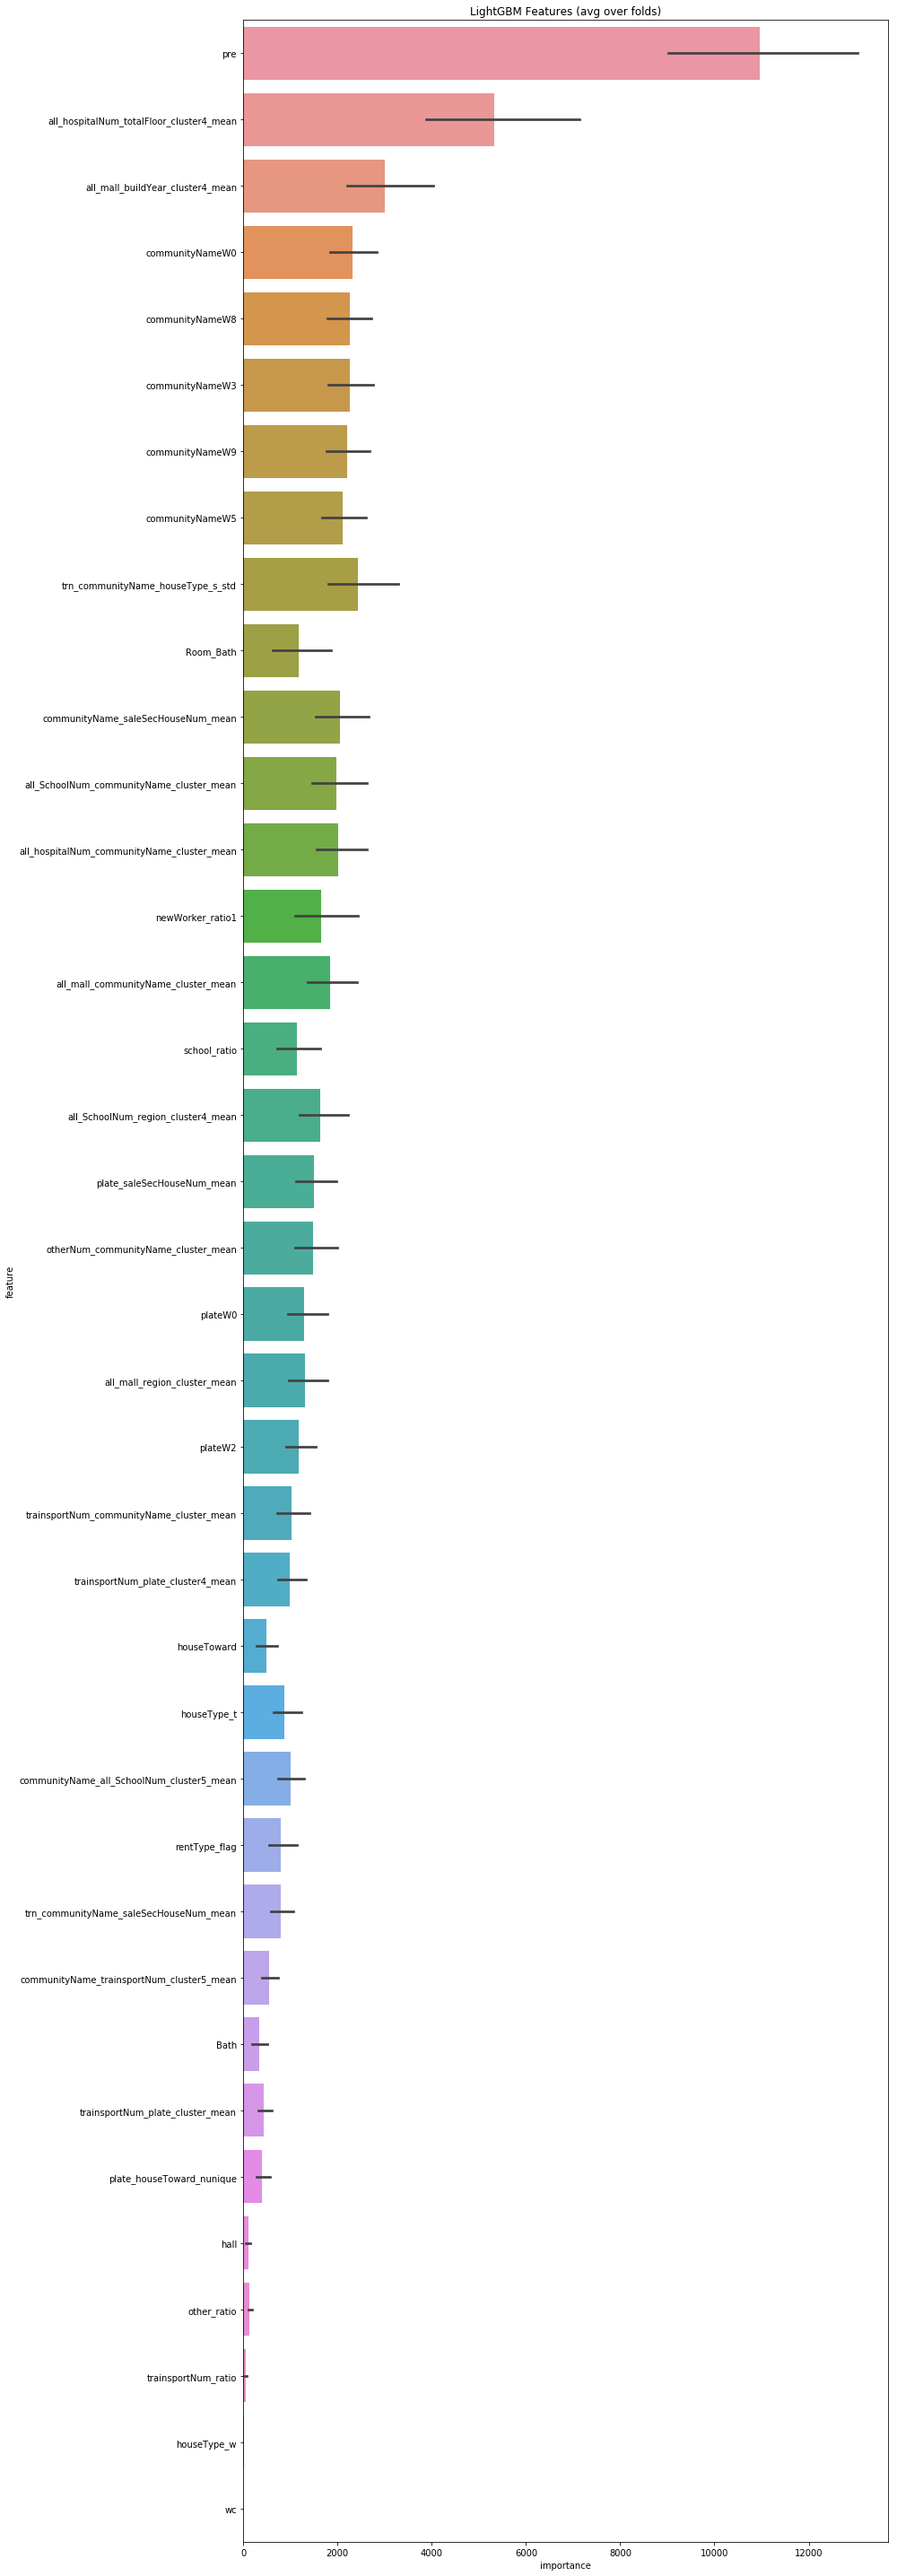

In [57]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [25]:
train["target"]

KeyError: 'target'

In [24]:
best_features[best_features["fold"] ==5].sort_values("importance",ascending = False)

,feature,importance,fold
708,target,36640,5
709,pre,25424,5
434,train_pre,8618,5
243,pre,8122,5
394,train_pre,7847,5
561,plate,7608,5
475,train_pre,6728,5
504,buildYear,6567,5
242,ID,4378,5
281,expected_newPrice,2928,5


In [26]:
fea_imp = feature_importance_df[feature_importance_df["importance"]>2000]["feature"].values

In [27]:
len(fea_imp)

41

### LGBM保存结果+ 简要分析

In [58]:
import datetime
def create_submission(prediction, score,model_name):
    now = datetime.datetime.now()
    sub_file = 'D:/城市-房产租金预测/result/submission_' +model_name+ str(score) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print ('Creating submission: ', sub_file)
#     print(predictions_lgb.min(),predictions_lgb.max())
    pd.DataFrame({ 'trademoney': prediction}).to_csv(sub_file, index=False,header=None)

model_name='lgbm'
score=r2_score(target, oof_lgb)
create_submission(predictions_lgb, score,model_name)

online_score(predictions_lgb)

Creating submission:  D:/城市-房产租金预测/result/submission_lgbm0.9609633792747249_2019-06-03-08-03.csv
预测结果最大值：15189.976286167977,预测结果最小值：1214.6236950592943
对比913分数:0.9744506831333505


## Lasso

In [ ]:
test.isnull().sum()

In [61]:
log1p_y_train = np.log1p(target)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =1e-9, random_state=5))

# 采用平滑后的y_train进行模型训练
lasso.fit(train, log1p_y_train)
# 对训练集预测
pred_log1p = lasso.predict(train)
# 模型评分
score = r2_score(log1p_y_train,pred_log1p)
print(score)
# 对测试集预测
pred = lasso.predict(test)
# 将测试集结果去掉平滑
lasso_pred = np.expm1(pred)
# 保存结果
pd.DataFrame(lasso_pred).to_csv("lasso_{}.csv".format(score),header=None,index=None)
print(online_score(lasso_pred))

# stacking_train = pd.DataFrame()
# stacking_test = pd.DataFrame()
# stacking_train["stacking_train_lasso"] = np.expm1(pred_log1p)
# stacking_test["stacking_test_lasso"] = lasso_pred
# stacking_train.shape,stacking_test.shape

0.8211197604216538
预测结果最大值：19436.17502330688,预测结果最小值：1163.6707979504226
对比913分数:0.8397834587649113
None


## ENet

In [ ]:

log1p_y_train = np.log1p(target)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=1e-9, l1_ratio=.59, random_state=5))
# 采用平滑后的y_train进行模型训练
ENet.fit(train, log1p_y_train)
# 对训练集预测
pred_log1p = ENet.predict(train)
# 模型评分
score = r2_score(log1p_y_train,pred_log1p)
print(score)
# 对测试集预测
ENet_pred = ENet.predict(test)
# 将测试集结果去掉平滑
ENet_pred = np.expm1(ENet_pred)
# 保存文件
pd.DataFrame(ENet_pred).to_csv("ENet_{}.csv".format(score),header=None,index=None)
online_score(ENet_pred)

# print(ENet_pred.max(),ENet_pred.min())
# 简要分析结果
# stacking_train["stacking_train_ENet"] = np.expm1(pred_log1p)
# stacking_test["stacking_test_ENet"] = ENet_pred
# model_ENet(train,test,target)



## GBDT

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.04,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 2333) 
GBoost.fit(train, target)
# 对训练集预测
pred_log1p = GBoost.predict(train)
# 模型评分
score = r2_score(target,pred_log1p)
print(score)
# 对测试集预测
GBoost_pred = GBoost.predict(test)
# 保存文件
pd.DataFrame(GBoost_pred).to_csv("GBoost_{}.csv".format(score),header=None,index=None)
# 简要分析结果
online_score(GBoost_pred)

# model_GBoost(X_scaled,test_X_scaled,label)
# stacking_train["stacking_train_GBoost"] = pred_log1p
# stacking_test["stacking_test_GBoost"] = GBoost_pred


# print(stacking_train.shape,stacking_test.shape)

## XGB

In [ ]:

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1,

                            )
# y_train = target
test.columns = train.columns
# 进行模型训练
model_xgb.fit(train, target)
# 对训练集预测
pred_log1p = model_xgb.predict(train)
# 模型评分
score = r2_score(target,pred_log1p)
print(score)
# 对测试集预测
xgb_pred = model_xgb.predict(test)
# 保存文件
pd.DataFrame(xgb_pred).to_csv("xgb_{}.csv".format(score),header=None,index=None)
online_score(xgb_pred)


# stacking_train["stacking_train_xgb"] = pred_log1p
# stacking_test["stacking_test_xgb"] = xgb_pred
# print(stacking_train.shape,stacking_test.shape)
model_XGB(train,test,target)

In [ ]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    "verbose":True
}
dtrain = xgb.DMatrix(train,label=target)
dtest  = xgb.DMatrix(test)

cv_res= xgb.cv(params,dtrain,num_boost_round=2000,early_stopping_rounds=30,nfold=5, metrics='rmse',show_stdv=True)
print(cv_res)
#cv_res.shape[0]为最佳迭代次数
bst = xgb.train(params,dtrain,num_boost_round=cv_res.shape[0])

y_pre = bst.predict(dtest)

In [ ]:
online_score(y_pre)

In [ ]:
# 对测试集进行预测
dtest = xgb.DMatrix(test)
ans = model.predict(dtest)

# 显示重要特征
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
online_score(ans)

In [ ]:
model_XGB(train,test,target)

## CatBoost

In [ ]:
import catboost as cb
model_cb = cb.CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.5,eval_metric = "R2",
                                leaf_estimation_method = "Newton",
                                l2_leaf_reg=3)
y_train = target
# 采用平滑后的y_train进行模型训练
model_cb.fit(train, y_train)
# 对训练集预测
pred_log1p = model_cb.predict(train)
# 模型评分
score = r2_score(y_train,pred_log1p)
print(score)
# 对测试集预测
CB_pred = model_cb.predict(test)
# 将测试集结果去掉平滑
# CB_pred = np.expm1(pred)


# stacking_train["stacking_train_CB"] = pred_log1p
# stacking_test["stacking_test_CB"] = CB_pred

# 简要分析结果
online_score(CB_pred)
# 保存文件
pd.DataFrame(CB_pred).to_csv("CB_{}.csv".format(score),header=None,index=None)

In [ ]:
online_score(CB_pred)

## StackingCVRegressor

In [ ]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=( GBoost, model_xgb, clf),
                                meta_regressor=clf,
                                use_features_in_secondary=True)
y_train = target
# 采用平滑后的y_train进行模型训练
# train1 = np.array(train.values)
# test1 = np.array(test.values)
# log1p_y_train = np.array(log1p_y_train.values)
stregr = stack_gen.fit(train, y_train)
# 对训练集预测
pred_log1p = stregr.predict(train)
# 模型评分
score = r2_score(y_train,pred_log1p)
print(score)
# 对测试集预测
stregr_pred = stregr.predict(test)
# 将测试集结果去掉平滑
# stregr_pred = np.expm1(stregr_pred)
print(stregr_pred.max(),stregr_pred.min())
# 保存文件
pd.DataFrame(stregr_pred).to_csv("stregr_{}.csv".format(score),header=None,index=None)


### 最简单的融合方式：平均值融合

In [ ]:

from sklearn.model_selection import KFold, cross_val_score, train_test_split
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)



In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 
#我们暂时只平均以下四个模型的值
#ENet, GBoost, KRR and lasso
 
averaged_models = AveragingModels(models = (ENet, GBoost, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))     
# Averaged base models score: 0.1091 (0.0075)
 
#看起来最简单的stacking策略也导致了分数的提升，这是我们去探索更多的方式


In [ ]:
  
#基线模型
 
#LASSO Regression :  该模型可能对异常值非常敏感。 所以我们需要让它们更加健壮。 为此，我们在管道上使用sklearn的Robustscaler（）方法
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
 
#Elastic Net Regression 同上
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
 
#Kernel Ridge Regression 
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
 
#Gradient Boosting Regression :huber损失有很好的鲁棒性
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
 
#xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                              nthread = -1)
 
#lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
 
#基线模型得分
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#Lasso score: 0.1115 (0.0074)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#ElasticNet score: 0.1116 (0.0074)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#Kernel Ridge score: 0.1153 (0.0075)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))  
#Gradient Boosting score: 0.1177 (0.0080)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))   
#Xgboost score: 0.1151 (0.0060)
 
# stacking model
 
#最简单的融合方式：平均值融合
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
#我们暂时只平均以下四个模型的值
#ENet, GBoost, KRR and lasso
 
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))     
# Averaged base models score: 0.1091 (0.0075)
 
#看起来最简单的stacking策略也导致了分数的提升，这是我们去探索更多的方式
 
#进阶版的stacking：  meta-model.
#把基础模型训练的结果作为特征继续训练模型
 
#Stacking averaged Models Class
 
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   # Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
        
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
#为了使结果具有可比性，我们使用相同的模型，因此lasso用于搭建第二层
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))        
#Stacking Averaged models score: 0.1085 (0.0074)
 
# Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
 
#StackedRegressor:    
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))    
#0.0781571937916
 
#XGBoost:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))
#0.0785366834315
 
#LightGBM:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))
#0.0734374313099
 
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))
 
 
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
 
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)    


### Stacking averaged Models Class

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)



In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

#为了使结果具有可比性，我们使用相同的模型，因此lasso用于搭建第二层
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))        
#Stacking Averaged models score: 0.1085 (0.0074)
 
 
#Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
 
#StackedRegressor:    
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))    
#0.0781571937916
 
#XGBoost:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))
#0.0785366834315
 
#LightGBM:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))
#0.0734374313099
 
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))
 
 
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
 
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False) 



####   Ensembling StackedRegressor, XGBoost and LightGBM

In [ ]:
def R2(y, y_pred):
    return r2_score(y, y_pred


# 模型保存/读取


## 模型保存

In [ ]:
from sklearn.externals import joblib
## 保存模型
joblib.dump(clf, "D:/城市-房产租金预测/model/clf.m")

## 模型读取

In [ ]:
## 模型读取
clf1 = joblib.load("D:/城市-房产租金预测/model/clf.m")

# 模型融合

In [ ]:
result = pd.DataFrame()
conmbine1= pd.read_csv("combine_17_2.csv",engine = "python",header = None)

conmbine2 = pd.read_csv("./best_result/sub_913.csv",engine = "python")
result["lgb"] = predictions_lgb
# result["lasso"] = lasso_pred
# result["ENet"] = ENet_pred
# result["conmbine1"] = conmbine1
# result["conmbine2"] = conmbine2
result["xgb"] = xgb_pred
result["GBoost"] = GBoost_pred
suma = result.T.sum()
result["mean"] = result.T.mean()
# result["max"] = result.T.max()
# result["min"] = result.T.min()
result[:10]

In [ ]:
result["weight"] = (predictions_lgb * 9 + xgb_pred * 6 + GBoost_pred * 8)/(6 +9 +8  )

In [ ]:
result["aaa"] =  (suma - result["max"] - result["min"])/2
result[:10]

In [ ]:
pd.DataFrame(result["aaa"]).to_csv("stregr_0.9962698506757866.csv",header=None,index=None)

In [ ]:
online_score(result["mean"] )

In [ ]:
result["aaa"] = result["aaa"].astype(int)

In [ ]:
test.shape,stacking_test.shape

In [ ]:
test.shape,test1.shape

In [ ]:
train1 = pd.concat([stacking_train,train],axis = 1)
test1 = pd.concat([stacking_test,test],axis = 1)
train1.shape,test1.shape

In [ ]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
stacking_train.index

In [ ]:
stacking_test.index

In [ ]:
# train.index=[i for i in range(train.shape[0])]
# test.index=[i for i in range(test.shape[0])]
stacking_train.index=[i for i in range(stacking_train.shape[0])]
stacking_test.index=[i for i in range(stacking_test.shape[0])]

In [ ]:
target = stacking_train.pop("stacking_train_lgb")

In [ ]:
target2 = stacking_test.pop("stacking_test_lgb")

In [ ]:
model_GBoost(stacking_train,stacking_test,target)data/

In [ ]:
model_XGB(stacking_train,stacking_test,target)

In [ ]:
stacking_train.shape

In [ ]:
stacking_test.shape

In [ ]:
target.shape

In [ ]:
stacking = pd.DataFrame()
stacking_GBoost= pd.read_csv("GBoost_0.9839561238711116.csv",engine = "python",header = None ) 
stacking_xgb= pd.read_csv("xgb_0.982638363777497.csv",engine = "python",header = None)
stacking_lgb= pd.read_csv("D:/城市-房产租金预测/result/submission_lgbm0.9142376086185616_2019-05-29-10-31.csv",engine = "python",header = None) 

In [ ]:
stacking = (stacking_GBoost + stacking_xgb + stacking_lgb)/3

In [ ]:
online_score(stacking)

In [ ]:
pd.DataFrame(stacking).to_csv("lgb_0.9842438659041761.csv",header=None,index=None)

NameError: name 'pd' is not defined